<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%206/assignment_6_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting CIFAR Dataset - Assignment 6

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load model

In [ ]:
#import model.py - contains model class which accepts type normalization method as input parameter

from model import Net

#instantiate Net class and check model summary

model = Net(dropout = 0.1).to(device)

summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
       BatchNorm2d-8           [-1, 64, 16, 16]             128
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
          Dropout-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
      BatchNorm2d-13           [-1, 64, 16, 16]             128
          Dropout-14           [-1, 64,

## Load Datasets

In [ ]:
# import function to load CIFAR dataset
from loadcifar import load_CIFAR

#set batch size
batch_size = 32

#define tranformations for train and test datasets

train_transform = A.Compose([
    A.HorizontalFlip(), # Same with transforms.RandomHorizontalFlip()
    A.ShiftScaleRotate(shift_limit = 0.06, scale_limit = 0.1, rotate_limit = 45),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=8, max_width=8, min_width=8, max_height=8, fill_value = [127,127,127], mask_fill_value = None, p=1),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

#load training dataset
classes, train_loader = load_CIFAR(train_transform, batch_size)
#load test dataset
_, test_loader = load_CIFAR(test_transform, batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


## View data

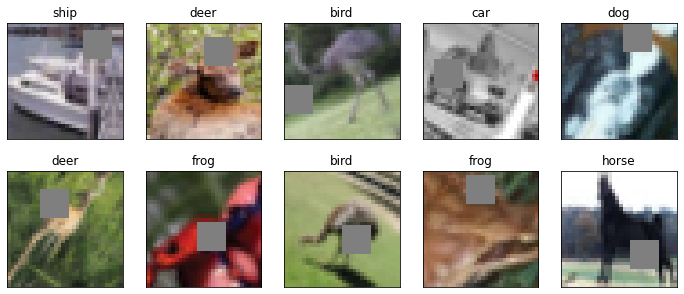

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = next(iter(train_loader))

no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


##Define parameters for training and train the network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
#import test function
from testfns import test

def train(model, train_loader, test_loader, device, epochs = 2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0.0

        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
        
        print("Epoch: ", epoch, "Learning Rate: ", optimizer.param_groups[0]["lr"])
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))    
        test(model, device, test_loader)

        #increment learning rate
        scheduler.step()

    print('Finished Training')

    return model

In [ ]:
model = train(model, train_loader, test_loader, device, epochs = 46)

Epoch:  0 Learning Rate:  0.1

Train set: Average loss: 1.6040, Accuracy: 20292.0/50000 (40.58%)


Test set: Average loss: 0.0112, Accuracy: 24352/50000 (48.70%)

Epoch:  1 Learning Rate:  0.1

Train set: Average loss: 1.6188, Accuracy: 23463.0/50000 (46.93%)


Test set: Average loss: 0.0110, Accuracy: 24269/50000 (48.54%)

Epoch:  2 Learning Rate:  0.1

Train set: Average loss: 1.6254, Accuracy: 26400.0/50000 (52.80%)


Test set: Average loss: 0.0095, Accuracy: 28459/50000 (56.92%)

Epoch:  3 Learning Rate:  0.1

Train set: Average loss: 1.2043, Accuracy: 28280.0/50000 (56.56%)


Test set: Average loss: 0.0084, Accuracy: 30922/50000 (61.84%)

Epoch:  4 Learning Rate:  0.1

Train set: Average loss: 1.3525, Accuracy: 29791.0/50000 (59.58%)


Test set: Average loss: 0.0086, Accuracy: 30481/50000 (60.96%)

Epoch:  5 Learning Rate:  0.1

Train set: Average loss: 1.2711, Accuracy: 30761.0/50000 (61.52%)


Test set: Average loss: 0.0073, Accuracy: 33776/50000 (67.55%)

Epoch:  6 Learning Rat

## Test Model

In [ ]:
#import test function
from testfns import test

test(model, device, test_loader)


Test set: Average loss: 0.0025, Accuracy: 44430/50000 (88.86%)



(0.0025282704731822013, 88.86)

## Generate miss classified images and View

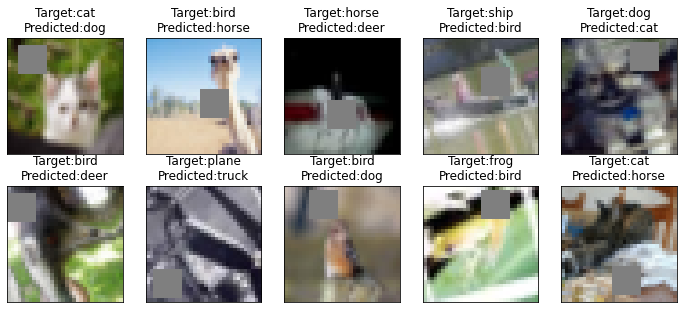

In [ ]:
#import function to plot misclassified images: get_miss_classified(model, device, images, labels)
from misclassified import get_miss_classified

images, labels = next(iter(train_loader))
images, targets, predictions = get_miss_classified(model, device, images, labels)

#plot 10 misclassified images
no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = "Target:" + str(classes[targets[index - 1]]) + "\nPredicted:" + str(
        classes[predictions[index - 1]])
    plt.title(title)

# Miss-classification by class

In [ ]:
#import function to calculate misclassifications getFractionsMissed(model, device, test_loader)

from misclassified import getFractionsMissed

x = getFractionsMissed(model, device, test_loader)
print(x)
print(classes)



{0: 0.0808, 1: 0.0352, 2: 0.1706, 3: 0.2606, 4: 0.1208, 5: 0.2166, 6: 0.0638, 7: 0.071, 8: 0.044, 9: 0.0506}
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


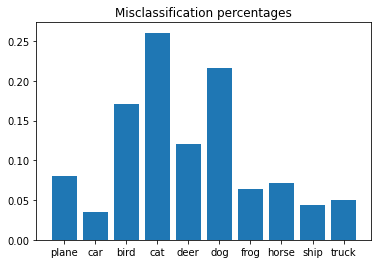

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(x)), list(x.values()), align='center')
plt.xticks(range(len(x)), list(classes))
plt.title("Misclassification percentages")
plt.show()